In [2]:
# Import required libraries
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.integrate import odeint
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

import lmfit
from tqdm.auto import tqdm
import pickle
import joblib

### Load spb covid-19 dataset

In [3]:
data = pd.read_csv('spb.combined.daily.txt', '\t', parse_dates=['TIME'], encoding='cp1251')

In [4]:
data.head()

,TIME,CONFIRMED,RECOVERED,DEATHS,ACTIVE,CONFIRMED.spb,HOSPITALIZED.today,PCR.tested,v1.CS,v2.CS,Yandex.ACTIVITY.points
0,2020-03-02,0,0,0,0,NaN,NaN,NaN,NaN,NaN,97.0
1,2020-03-03,0,0,0,0,NaN,NaN,NaN,NaN,NaN,100.0
2,2020-03-04,1,0,0,1,NaN,NaN,NaN,NaN,NaN,99.0
3,2020-03-05,0,0,0,1,NaN,NaN,NaN,NaN,NaN,99.0
4,2020-03-06,1,0,0,2,NaN,NaN,NaN,NaN,NaN,100.0


### Considering the first phase

In [5]:
data1 = data[data.TIME <= '2020-06-30']

In [6]:
data1.drop(['Yandex.ACTIVITY.points', 'v1.CS', 'v2.CS', 'CONFIRMED.spb', 'PCR.tested'], axis =1 , inplace = True)

/home/pk/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:4167: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [7]:
data1.fillna(0, inplace = True )

/home/pk/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:4321: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


In [8]:
data1

,TIME,CONFIRMED,RECOVERED,DEATHS,ACTIVE,HOSPITALIZED.today
0,2020-03-02,0,0,0,0,0.0
1,2020-03-03,0,0,0,0,0.0
2,2020-03-04,1,0,0,1,0.0
3,2020-03-05,0,0,0,1,0.0
4,2020-03-06,1,0,0,2,0.0
...,...,...,...,...,...,...
116,2020-06-26,224,716,57,6242,525.0
117,2020-06-27,217,598,21,5840,358.0
118,2020-06-28,219,247,19,5793,216.0
119,2020-06-29,253,254,31,5761,375.0


### Plot of active cases dring first wave

<AxesSubplot:>

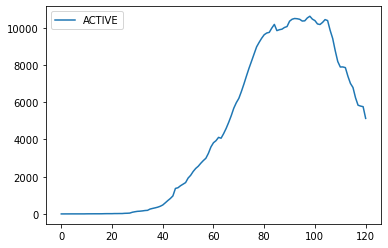

In [9]:
data1.ACTIVE.plot(legend = True)

<AxesSubplot:>

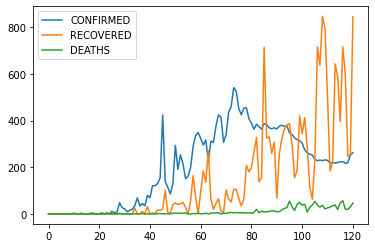

In [10]:
data1.CONFIRMED.plot(legend = True)
data1.RECOVERED.plot(legend = True)
data1.DEATHS.plot(legend = True)

### Building SIER model. 


In [11]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# parameter values
R0 = 1.0889
t_incubation = 0.106
t_infective = 0.649

# initial number of infected and recovered individuals
e_initial = 1/4000000
i_initial = 0.00
r_initial = 0.00
s_initial = 1 - e_initial - i_initial - r_initial

alpha = 1/t_incubation
gamma = 1/t_infective
beta = R0*gamma

# SEIR model differential equations.
def deriv(x, t, alpha, beta, gamma):
    s, e, i, r = x
    dsdt = -beta * s * i
    dedt =  beta * s * i - alpha * e
    didt = alpha * e - gamma * i
    drdt =  gamma * i
    return [dsdt, dedt, didt, drdt]


t = np.linspace(0, 121, 121)
x_initial = s_initial, e_initial, i_initial, r_initial
soln = odeint(deriv, x_initial, t, args=(alpha, beta, gamma))
s, e, i, r = soln.T


#### Find the best parameters to fit the model

In [12]:
R0 = np.arange(1.088, 1.089, 0.0001)
t_incubation = np.arange(0.1, 0.2, 0.001)
t_infective = np.arange(0.45, 0.65, 0.001)

In [13]:
# r2_scores = {}
# for x in R0:
#     for y in t_incubation:
#         for z in t_infective:
#             alpha = 1/y
#             gamma = 1/z
#             beta = x*gamma
#             soln = odeint(deriv, x_initial, t, args=(alpha, beta, gamma))
#             s, e, i, r = soln.T
#             R2 = r2_score(data1['ACTIVE'][:], i*4000000 )
#             r2_scores[f'R0:{x}, t_incubation:{y}, t_infective:{z}'] = R2


In [14]:
# sorted(r2_scores.items(), key=lambda x: x[1], reverse=True)

#### Best parameters obtained are 
R0 = 1.0889
t_incubation = 0.106
t_infective = 0.649

#### Plot of actual and predicted active cases

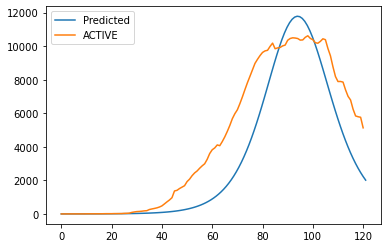

In [15]:
plt.plot(t, i*4000000, label='Predicted')
((data1.ACTIVE)).plot(legend = True)
plt.legend()

In [16]:
R2 = r2_score(data1['ACTIVE'][:], i*4000000 )
R2

0.7737791695895329

### R2 score for the model is 0.7737791695895329

## MCMC for finding best parameters for SEIR model

## Metropolis hasting calibrated with SEIR

In [17]:
# import required packages
import numpy as np
import os
import scipy.io as sio
from scipy.integrate import odeint
from pymcmcstat.MCMC import MCMC
from pymcmcstat.plotting import MCMCPlotting
import matplotlib.pyplot as plt
import pymcmcstat
import pandas as pd
print(pymcmcstat.__version__)
np.seterr(over='ignore');

1.9.1


In [18]:
# tx corresponds to the days, and ty to the active cases
tx = np.arange(len(data1))
ty = data1[['CONFIRMED', 'ACTIVE', 'RECOVERED' ]].values

In [19]:
# Build a loss function (sum of squares)
def covid_ss(theta, data):
    # sum-of-squares function for covid example
    ndp, nbatch = data.shape[0]
    time = tx
    ydata = ty
    xdata = data.user_defined_object[0]
    # last 3 parameters are the initial states
    y0 = x_initial
    # evaluate model
    tmodel, ymodel = covid_fun(time, theta, y0, xdata)
#     a_model = np.cumsum(ymodel[:,2]-(ymodel[:,3]+ymodel[:,4]))
    res = ymodel[:,2] - ty[:,1]/4000000
    ss = (res**2).sum(axis=0)
    return ss  

# Building SIERD model
def covid_fun(time, theta, y0, xdata  = None):
    soln = odeint(covid_sys, y0, time, args=(theta, xdata))
#     s, e, i, r = soln.T   
    return time, soln


e_initial = 1/4000000
i_initial = 0.00
r_initial = 0.00
s_initial = 1 - e_initial - i_initial - r_initial
x_initial = s_initial, e_initial, i_initial, r_initial

def covid_sys(y, t ,theta, xdata = None):
    s, e, i, r = y
    
    R0 = theta[0]
    t_incubation = theta[1]
    t_infective = theta[2]
    alpha = 1/t_incubation
    gamma = 1/t_infective
    beta = R0*gamma
    
#     s, e, i, r = x
    dsdt = -beta * s * i
    dedt =  beta * s * i - alpha * e
    didt = alpha * e - gamma * i
    drdt =  gamma * i
    ydot = np.array([dsdt, dedt, didt, drdt])
    return ydot


In [20]:
# initialize MCMC object
mcstat = MCMC()
# initialize data structure 
mcstat.data.add_data_set(x=tx,
                         y=ty[:,:],
                         user_defined_object=tx)
# initialize parameter array
# add model parameters
# Intially population o SPB is considered as 10000000 and all the intial parameters for SIERD model are defined
mcstat.parameters.add_model_parameter(name='R0', theta0=1.0889, minimum=0, maximum = 2)
mcstat.parameters.add_model_parameter(name='t_incubation', theta0=0.106, minimum=0, maximum=2)
mcstat.parameters.add_model_parameter(name='t_infective', theta0=0.649, minimum=0, maximum=2)
                                  


# Generate options
mcstat.simulation_options.define_simulation_options(nsimu=1.0e3, updatesigma=True)


In [21]:
# Define model object:

mcstat.model_settings.define_model_settings(
    sos_function=covid_ss)

In [22]:
# # check model evaluation
# theta = [1.0889, 0.106, 0.649]
# ss = covid_ss(theta, mcstat.data)
# print('ss = {}'.format(ss))

In [23]:
# Run simulation
mcstat.run_simulation()
# Rerun starting from results of previous run
mcstat.simulation_options.nsimu = int(5.0e3)
mcstat.run_simulation(use_previous_results=True)


Sampling these parameters:
      name      start [      min,       max] N(       mu,   sigma^2)
        R0:      1.09 [ 0.00e+00,      2.00] N( 0.00e+00,      inf)
t_incubation:      0.11 [ 0.00e+00,      2.00] N( 0.00e+00,      inf)
t_infective:      0.65 [ 0.00e+00,      2.00] N( 0.00e+00,      inf)
 [-----------------100%-----------------] 1000 of 1000 complete in 2.6 sec
Sampling these parameters:
      name      start [      min,       max] N(       mu,   sigma^2)
        R0:      1.09 [ 0.00e+00,      2.00] N( 0.00e+00,      inf)
t_incubation:  1.91e-03 [ 0.00e+00,      2.00] N( 0.00e+00,      inf)
t_infective:      0.74 [ 0.00e+00,      2.00] N( 0.00e+00,      inf)
 [-----------------100%-----------------] 5000 of 5000 complete in 10.9 sec



------------------------------
      name:      mean       std    MC_err       tau    geweke
        R0:      1.09  2.27e-03  1.11e-04     11.87      1.00
t_incubation:      0.03      0.03  1.48e-03     13.02      0.91
t_infective:      0.73      0.02  1.29e-03     15.37      0.99
------------------------------
Acceptance rate information
---------------
Results dictionary:
Stage 1: 19.02%
Stage 2: 50.48%
Net    : 69.50% -> 3475/5000
---------------
Chain provided:
Net    : 72.08% -> 2522/3499
---------------
Note, the net acceptance rate from the results dictionary
may be different if you only provided a subset of the chain,
e.g., removed the first part for burnin-in.
------------------------------


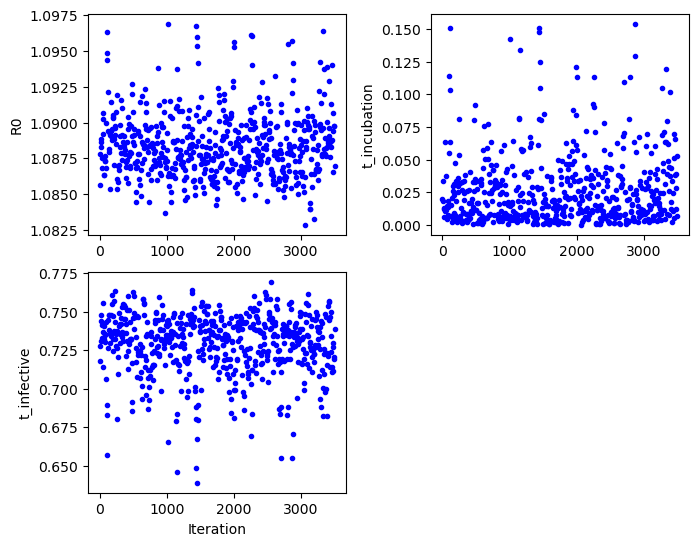

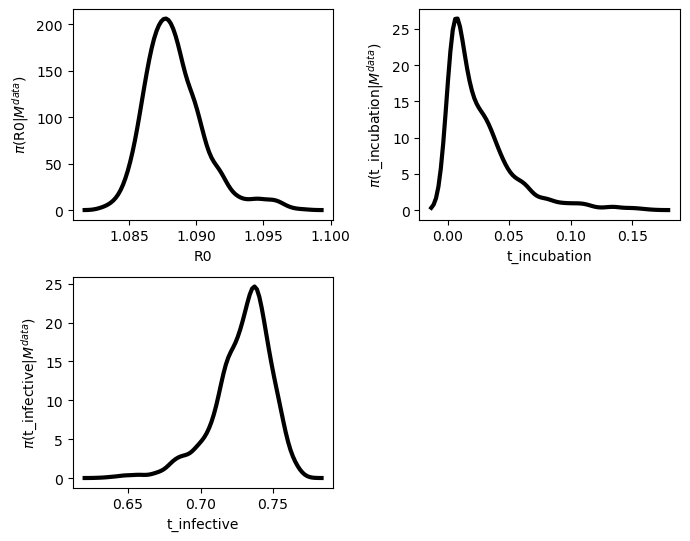

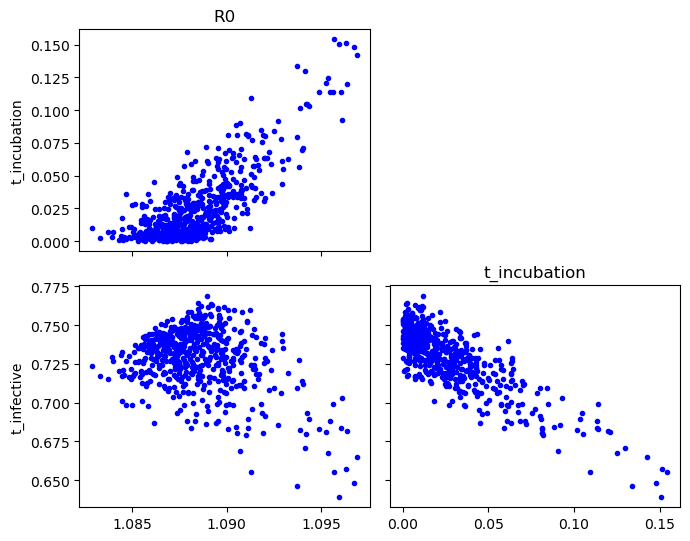

In [24]:
# extract info from results
results = mcstat.simulation_results.results
burnin = int(results['nsimu']/2)
chain = results['chain'][burnin:, :]
s2chain = results['s2chain'][burnin:, :]
names = results['names'] # parameter names

# display chain stats
mcstat.chainstats(chain, results)

from pymcmcstat import mcmcplot as mcp
settings = dict(
    fig=dict(figsize=(7, 6))
)
# plot chain panel
mcp.plot_chain_panel(chain, names, settings)
# plot density panel
mcp.plot_density_panel(chain, names, settings)
# pairwise correlation
f = mcp.plot_pairwise_correlation_panel(chain, names, settings)

### Optimal Parameters predicted using MCMC.
R0 = 1.09
t_incubation = 0.11
t_infective = 0.67

In [25]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# parameter values
R0 = 1.09
t_incubation = 0.02
t_infective = 0.73

# initial number of infected and recovered individuals
e_initial = 1/4000000
i_initial = 0.00
r_initial = 0.00
s_initial = 1 - e_initial - i_initial - r_initial

alpha = 1/t_incubation
gamma = 1/t_infective
beta = R0*gamma
# delta = 
# rho = 

# SEIR model differential equations.
def deriv(x, t, alpha, beta, gamma):
    s, e, i, r = x
    dsdt = -beta * s * i
    dedt =  beta * s * i - alpha * e
    didt = alpha * e - gamma * i
    drdt =  gamma * i
    return [dsdt, dedt, didt, drdt]


t = np.linspace(0, 121, 121)
x_initial = s_initial, e_initial, i_initial, r_initial
soln = odeint(deriv, x_initial, t, args=(alpha, beta, gamma))
s, e, i, r = soln.T


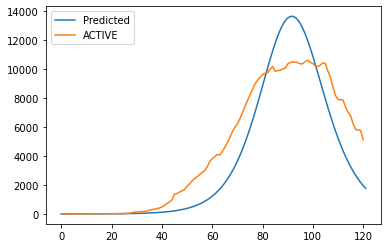

In [26]:
plt.plot(t, i*4000000, label='Predicted')
((data1.ACTIVE)).plot(legend = True)
plt.legend()

In [27]:
R2 = r2_score(data1['ACTIVE'][:], i*4000000 )
R2

0.7823574162110154

### R2 score for the model calibrated with MCMC to find the best parameters is 0.7775169378287957


In [29]:
from pymcmcstat import propagation as up

def predmodel(q, data):
    obj = data.user_defined_object[0]
    time = obj[:]
    xdata = obj
    # last 3 parameters are the initial states
    y0 = x_initial
    # evaluate model
    ymodel = np.zeros([time.size])
    tmodel, ymodel = covid_fun(time, q, y0, xdata)
    return ymodel

pdata = mcstat.data
intervals = up.calculate_intervals(chain, results, pdata, predmodel,
                                  waitbar=True, s2chain=s2chain)

 [-----------------100%-----------------] 500 of 500 complete in 0.7 sec

#### Get the predictions from the distribution of data

In [30]:
# getting the predictions from the generated 500 samples for each day.
pred = []
for i in range(len(data1)):
    pred.append(intervals[2]['prediction'][:,i].mean())

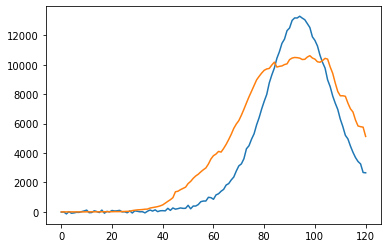

In [31]:
plt.plot(np.arange(121), np.array(pred)*4000000)
plt.plot(mcstat.data.xdata[0][:,0],mcstat.data.ydata[0][:,1])


In [32]:
R2 = r2_score(mcstat.data.ydata[0][:,1], np.array(pred)*4000000)
R2

0.8067637520355608

### R2 score for the model calibrated with MCMC to find the best parameters is 0.7940174702659524